In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import pytorch_lightning as pl

from torch_geometric.data import DataLoader
import pytorch_lightning as pl
import os.path as osp

from tqdm import tqdm

from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

In [2]:
%cd ..

/nfs/homedirs/fuchsgru/MastersThesis


In [3]:
import configuration
import model_registry
import data.build
import data.constants as dconst
import model.constants as mconst
from data.util import data_get_num_attributes, data_get_num_classes
from model.semi_supervised_node_classification import SemiSupervisedNodeClassification, Ensemble
from evaluation.util import get_data_loader, run_model_on_datasets, separate_distributions
import evaluation.callbacks as ecbs
from metrics import expected_calibration_error
from plot.calibration import plot_calibration
from data.util import label_binarize
from model.density import get_density_model
import seed
from train import train_model
from model.build import make_model

In [4]:
import logging as l

l.basicConfig(level=l.INFO)

In [5]:
registry = model_registry.ModelRegistry()

In [6]:
dataset = dconst.AMAZON_PHOTO

reco_conf = {'model' : {
        'reconstruction' : {
            'loss_weight' : 1.0, # Use for BCE-based  and mconstants.ENERGY
            'reconstruction_type' : mconst.ENERGY,
        }
    },}

training_cfg = {
    'early_stopping' : {
        'patience' : 50,
        'min_delta' : 0.01,
    }
}

setting = dconst.HYBRID

config = configuration.ExperimentConfiguration(
    data={
        'dataset' : dataset,
        'setting' : setting,
        'ood_type' : dconst.LEFT_OUT_CLASSES,
        # 'use_dataset_registry' : False,
    },
    run = {
        'use_default_configuration' : True,
    },
    model = {
        'use_bias' : True,
    },
    training = training_cfg,
)
config_norm = configuration.ExperimentConfiguration(
    data={
        'dataset' : dataset,
        'setting' : setting,
        'ood_type' : dconst.LEFT_OUT_CLASSES,
        # 'use_dataset_registry' : False,
    },
    **reco_conf,
    run = {
        'use_default_configuration' : True,
    },
    training = training_cfg,
)
if config.run.use_default_configuration:
    configuration.update_with_default_configuration(config)
    configuration.update_with_default_configuration(config_norm)
    
config.model.use_bias = True
config_norm.model.use_bias = True
    
print(config.run.use_default_configuration)

INFO:root:Set configuration value data.base_labels to default all
INFO:root:Set configuration value data.corpus_labels to default all
INFO:root:Set configuration value data.train_labels to default all
INFO:root:Set configuration value data.left_out_class_labels to default ['Film Photography', 'Binoculars & Scopes', 'Video Surveillance']
INFO:root:Set configuration value data.preprocessing to default none
INFO:root:Set configuration value data.ood_sampling_strategy to default all
INFO:root:Set configuration value data.train_portion to default 20
INFO:root:Set configuration value data.test_portion_fixed to default 0.2
INFO:root:Set configuration value data.split_type to default uniform
INFO:root:Set configuration value data.type to default npz
INFO:root:Set configuration value data.drop_train_vertices_portion to default 0.1
INFO:root:Set configuration value data.precompute_k_hop_neighbourhood to default 2
INFO:root:Set configuration value model.hidden_sizes to default [64]
INFO:root:Set 

True


In [7]:
config.data.setting

'hybrid'

In [8]:
if torch.cuda.is_available():
    config.training.gpus = 1
    config_norm.training.gpus = 1
    
config.training.gpus = 0
config_norm.training.gpus = 0
    

In [9]:
config.run.use_pretrained_model = True
config_norm.run.use_pretrained_model = True

In [10]:
data_split_seed = seed.data_split_seeds()[config.run.split_idx]
config.registry.split_seed = data_split_seed
model_seed_generator = iter(seed.SeedIterator(seed.model_seeds()[config.run.initialization_idx]))
data_dict, fixed_vertices = data.build.load_data_from_configuration(config.data, data_split_seed)
data_loaders = {
    name : DataLoader(data, batch_size=1, shuffle=False) for name, data in data_dict.items()
}

INFO:root:Found precomputed dataset split at /nfs/students/fuchsgru/dataset_registry/2111899493.pt
/nfs/homedirs/fuchsgru/miniconda3/lib/python3.9/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [11]:
model_seed = next(model_seed_generator)

In [12]:
run_artifact_dir = artifact_dir = osp.join(config.logging.artifact_dir, 'edge-reco-nb-sensitivity')

In [13]:
class LoggingCallback(pl.callbacks.Callback):
    
    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        if trainer.global_step % 100 != 0:
            return
        
        l.info(' '.join(
            map(str, ['Epoch', trainer.global_step, 'acc', (pl_module(batch).get_predictions()[batch.mask].argmax(1) == batch.y[batch.mask]).float().mean().item()])
        
        ))
        

In [14]:
config.registry.model_seed = model_seed
pl.seed_everything(model_seed)
model = make_model(config, data_get_num_attributes(data_dict[dconst.TRAIN][0]), 
    data_get_num_classes(data_dict[dconst.TRAIN][0]))
print(model.log_temperature)
print(model)
model = train_model(model, config, artifact_dir, data_loaders, logger=None, callbacks=[LoggingCallback()]).eval()

Global seed set to 1952926171
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Parameter containing:
tensor([0.], requires_grad=True)
SemiSupervisedNodeClassification(
  (backbone): GCN(
    (convs): ModuleList(
      (0): BasicBlock(
        (conv): GCNConv
          LinearWithParametrization(
            (linear): Linear(in_features=745, out_features=64, bias=True)
          )
        (act): LeakyReLU(negative_slope=0.01)
      )
      (1): BasicBlock(
        (conv): GCNConv
          LinearWithParametrization(
            (linear): Linear(in_features=64, out_features=5, bias=True)
          )
      )
    )
  )
)


INFO:root:Found pre-trained model at /nfs/students/fuchsgru/model_registry/2570722568.ckpt
INFO:root:Loading model for evaluation from /nfs/students/fuchsgru/model_registry/2570722568.ckpt.


In [15]:
model.log_temperature

Parameter containing:
tensor([0.], requires_grad=True)

In [16]:
np.linalg.svd(model.get_weights()['backbone.conv0.lin.weight'].cpu().detach().numpy(), full_matrices=False)[1]

array([1.03236408e+01, 9.40070152e+00, 8.68776608e+00, 6.99364519e+00,
       1.42674041e+00, 3.81743461e-01, 3.56806040e-01, 3.02712351e-01,
       2.64687777e-01, 2.28835657e-01, 2.23916546e-01, 1.89318880e-01,
       1.80258796e-01, 1.52832404e-01, 1.36781752e-01, 1.25691637e-01,
       1.15259156e-01, 1.03797570e-01, 9.99646708e-02, 9.24702659e-02,
       8.11942369e-02, 7.87171870e-02, 7.41377026e-02, 6.94893971e-02,
       6.82131499e-02, 6.17875457e-02, 5.89106642e-02, 5.71015477e-02,
       5.55034466e-02, 5.47363162e-02, 5.35092950e-02, 4.66101356e-02,
       4.50047031e-02, 4.38851416e-02, 4.09625135e-02, 4.00405303e-02,
       3.63002568e-02, 3.51366587e-02, 3.48738246e-02, 3.41494530e-02,
       3.20229381e-02, 3.02844755e-02, 2.85519958e-02, 2.72201654e-02,
       2.62432545e-02, 2.56277863e-02, 2.41468586e-02, 2.34889071e-02,
       2.25407928e-02, 2.23594718e-02, 2.09206901e-02, 1.80283077e-02,
       1.74863301e-02, 1.62263494e-02, 1.51571864e-02, 1.37564661e-02,
      

In [17]:
config_norm.registry.model_seed = model_seed
pl.seed_everything(model_seed)
model_norm = make_model(config_norm, data_get_num_attributes(data_dict[dconst.TRAIN][0]), 
    data_get_num_classes(data_dict[dconst.TRAIN][0]))
print(model_norm)
model_norm = train_model(model_norm, config_norm, artifact_dir, data_loaders, logger=None, callbacks=[LoggingCallback()]).eval()

Global seed set to 1952926171
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


SemiSupervisedNodeClassification(
  (backbone): GCN(
    (convs): ModuleList(
      (0): BasicBlock(
        (conv): GCNConv
          LinearWithParametrization(
            (linear): Linear(in_features=745, out_features=64, bias=True)
          )
        (act): LeakyReLU(negative_slope=0.01)
      )
      (1): BasicBlock(
        (conv): GCNConv
          LinearWithParametrization(
            (linear): Linear(in_features=64, out_features=5, bias=True)
          )
      )
    )
  )
  (reconstruction_loss): ReconstructionLoss()
)


INFO:root:Found pre-trained model at /nfs/students/fuchsgru/model_registry/8913873511487021889-1650807815-918064-3458505500.ckpt
INFO:root:Loading model for evaluation from /nfs/students/fuchsgru/model_registry/8913873511487021889-1650807815-918064-3458505500.ckpt.


In [18]:
model = model.cpu()
model_norm = model_norm.cpu()

In [19]:
model.clear_and_disable_cache()
model_norm.clear_and_disable_cache()

INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.


In [20]:
# Check accuracy of both models
with torch.no_grad():
    data_val = data_dict[dconst.VAL][0]
    pred_val = model(data_val)
    pred_val_norm = model_norm(data_val)
    
    acc_val = (pred_val.get_predictions()[data_val.mask].argmax(1) == data_val.y[data_val.mask]).float().mean()
    acc_val_norm = (pred_val_norm.get_predictions()[data_val.mask].argmax(1) == data_val.y[data_val.mask]).float().mean()

    print(acc_val, acc_val_norm)

tensor(0.9200) tensor(0.9300)


In [21]:
(pred_val.get_predictions()[data_val.mask].argmax(1) == data_val.y[data_val.mask]).float().mean()

tensor(0.9200)

In [22]:
np.linalg.svd(model.get_weights()['backbone.conv0.lin.weight'].cpu().detach().numpy(), full_matrices=False)[1]

array([1.03236408e+01, 9.40070152e+00, 8.68776608e+00, 6.99364519e+00,
       1.42674041e+00, 3.81743461e-01, 3.56806040e-01, 3.02712351e-01,
       2.64687777e-01, 2.28835657e-01, 2.23916546e-01, 1.89318880e-01,
       1.80258796e-01, 1.52832404e-01, 1.36781752e-01, 1.25691637e-01,
       1.15259156e-01, 1.03797570e-01, 9.99646708e-02, 9.24702659e-02,
       8.11942369e-02, 7.87171870e-02, 7.41377026e-02, 6.94893971e-02,
       6.82131499e-02, 6.17875457e-02, 5.89106642e-02, 5.71015477e-02,
       5.55034466e-02, 5.47363162e-02, 5.35092950e-02, 4.66101356e-02,
       4.50047031e-02, 4.38851416e-02, 4.09625135e-02, 4.00405303e-02,
       3.63002568e-02, 3.51366587e-02, 3.48738246e-02, 3.41494530e-02,
       3.20229381e-02, 3.02844755e-02, 2.85519958e-02, 2.72201654e-02,
       2.62432545e-02, 2.56277863e-02, 2.41468586e-02, 2.34889071e-02,
       2.25407928e-02, 2.23594718e-02, 2.09206901e-02, 1.80283077e-02,
       1.74863301e-02, 1.62263494e-02, 1.51571864e-02, 1.37564661e-02,
      

In [23]:
torch.allclose(pred_val.get_predictions() , pred_val_norm.get_predictions())

False

In [24]:
from data.transform import PerturbationTransform

In [25]:
data_train = data_dict[dconst.TRAIN][0]
data_val = data_dict[dconst.VAL][0]

In [26]:
# The ground truth is used for fitting labeled data (train and val)
gnd_binary = torch.zeros(data_train.x.size(0), int(data_train.y.max() + 1))
gnd_binary[torch.arange(gnd_binary.size(0)), data_train.y] = 1

gnd_binary.sum(1)

tensor([1., 1., 1.,  ..., 1., 1., 1.])

In [27]:
with torch.no_grad():
    pred_train = model(data_train)
    pred_val = model(data_val)
    density_model = get_density_model(
        density_type='GaussianPerClass',
        covariance='diag',
        regularization=False,
        fit_val=True,
    )
    density_model.fit(
        pred_train.get_features(-2)[data_train.mask], 
        gnd_binary[data_train.mask], 
        pred_val.get_features(-2)[data_val.mask],
        gnd_binary[data_val.mask],
    )

In [28]:
with torch.no_grad():
    pred_train_norm = model_norm(data_train)
    pred_val_norm = model_norm(data_val)
    density_model_norm = get_density_model(
        density_type='GaussianPerClass',
        covariance='diag',
        regularization=False,
        fit_val=True,
    )
    density_model_norm.fit(
        pred_train_norm.get_features(-2)[data_train.mask], 
        gnd_binary[data_train.mask], 
        pred_val_norm.get_features(-2)[data_val.mask],
        gnd_binary[data_val.mask],
    )
    

# Sensitivity to Ego-Graph purity

In [29]:
from evaluation.util import *

In [30]:
data_ood = data_loaders[dconst.OOD_TEST].dataset[0]
data_ood.x.size(), data_ood.y.max()

(torch.Size([7487, 745]), tensor(7))

In [31]:
with torch.no_grad():
    pred_ood = model(data_ood)
    pred_ood_norm = model_norm(data_ood)

In [32]:
fraction_id_nbs = count_id_neighbours(
    [data_loaders[dconst.OOD_TEST]],
    2,
    mask=True,
    fraction=True
)

In [33]:
fraction_id_nbs.size(), data_ood.mask.sum()

(torch.Size([480, 3]), tensor(480))

In [34]:
ood_distribution_labels = get_ood_distribution_labels(
fraction_id_nbs, threshold=.1)
ood_labels, ood_mask = separate_distributions(ood_distribution_labels, 'ood-and-neighbourhood')

In [35]:
ood_labels.size(), ood_mask.size(), ood_mask.sum()

(torch.Size([480]), torch.Size([480]), tensor(401))

In [36]:
# Use effective labels

is_id = ood_labels
emb = pred_ood.get_features(-2)[data_ood.mask]
emb_norm = pred_ood_norm.get_features(-2)[data_ood.mask]
density_emb = density_model(emb)
density_emb_norm = density_model_norm(emb_norm)


In [37]:
alea = pred_ood.get_predictions()[data_ood.mask].max(dim=1)[0]
alea_norm = pred_ood_norm.get_predictions()[data_ood.mask].max(dim=1)[0]

In [38]:
roc_auc_score(
    is_id[ood_mask].cpu().numpy(),
    density_emb[ood_mask].cpu().numpy(),
)

0.75

In [39]:
roc_auc_score(
    is_id[ood_mask].cpu().numpy(),
    density_emb_norm[ood_mask].cpu().numpy(),
)

0.8926767676767677

In [40]:
from plot.density import *

In [41]:
features_fit = torch.cat([pred_train.get_features(-2)[data_train.mask], pred_train.get_features(-2)[data_val.mask]])
features_fit_norm = torch.cat([pred_train_norm.get_features(-2)[data_train.mask], pred_train_norm.get_features(-2)[data_val.mask]])

In [42]:
embs, is_fit, grids, grid_inverses = get_dimensionality_reduction_to_plot(
    features_fit, emb, ['umap']
)

In [43]:
embs_norm, is_fit_norm, grids_norm, grid_inverses_norm = get_dimensionality_reduction_to_plot(
    features_fit_norm, emb_norm, ['umap']
)

In [44]:
nx, ny = grids['umap'].shape[0], grids['umap'].shape[1]
density_grid = density_model(torch.from_numpy(grid_inverses['umap'].reshape(nx * ny, -1))).cpu().numpy().reshape((nx, ny))

In [45]:
nx, ny = grids_norm['umap'].shape[0], grids_norm['umap'].shape[1]
density_grid_norm = density_model_norm(torch.from_numpy(grid_inverses_norm['umap'].reshape(nx * ny, -1))).cpu().numpy().reshape((nx, ny))

In [46]:
# Plotting

In [47]:
def limits_to_levels(x, res=10, n=10, conf=.95):
    
    s = x.clone().cpu().numpy()
    s.sort()
    first = int(s.shape[0] * (1 - conf) / 2)
    last = int(s.shape[0] * (conf + (1 - conf) / 2))
    vmin = int(s[first] / res)
    vmax = int(s[last] / res)
    #vmin = int((x.mean() - x.std()).item() / res)
    #vmax = int((x.mean() + x.std()).item() / res)
    print(s)
    print(res * vmin, res * vmax)
    return res * np.linspace(vmin, vmax, n + 1)

In [48]:
import matplotlib.colors as mc
cmap_arr = np.ones((256, 4))
cmap_arr[:, :3] *= np.linspace(1, 0.4, 256)[:, None]
cmap = mc.ListedColormap(cmap_arr)

In [49]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False
mpl.rcParams['text.latex.preamble'] = [] #for \text command

<ipython-input-49-741fa30a58ad>:3: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  mpl.rcParams['text.latex.preamble'] = [] #for \text command


[-7.41043091e+02 -4.02122528e+02 -2.37582153e+02 -2.29342590e+02
 -1.97196686e+02 -1.84358459e+02 -1.39345093e+02 -1.35249207e+02
 -9.39910889e+01 -9.22152710e+01 -8.36719971e+01 -5.42039795e+01
 -5.32002106e+01 -5.26378479e+01 -5.23767700e+01 -4.81614380e+01
 -4.49628601e+01 -4.28628235e+01 -3.75164948e+01 -3.72122345e+01
 -3.70469360e+01 -3.48848877e+01 -3.44383011e+01 -3.30715179e+01
 -2.83989887e+01 -2.79407978e+01 -2.60793629e+01 -2.43970966e+01
 -2.36692982e+01 -2.28478260e+01 -2.27939167e+01 -2.23169136e+01
 -2.16843433e+01 -1.78050251e+01 -1.69621563e+01 -1.66493855e+01
 -1.64053059e+01 -1.52989521e+01 -1.48048573e+01 -1.26537189e+01
 -8.75341988e+00 -8.72591877e+00 -7.12592888e+00 -6.72236824e+00
 -6.53907967e+00 -4.35388374e+00 -3.46237373e+00 -3.12965584e+00
 -7.62987137e-01 -6.24177933e-01 -7.96072185e-02  6.42256737e-02
  4.32016581e-01  1.49733341e+00  1.90682185e+00  2.25597954e+00
  3.00481224e+00  3.16100597e+00  3.96541405e+00  4.21824455e+00
  4.76884317e+00  4.81765

INFO:matplotlib.mathtext:Substituting symbol N from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol N from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol N from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol N from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol N from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol N from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol N from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol N from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol N from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol N from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol N from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol N from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol N from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol N from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol N from STIXNonUni

thesis_nbs/edge_reconstruction_nb_sensitivity/amazon_photo-hybrid.pdf


INFO:matplotlib.mathtext:Substituting symbol N from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol N from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol N from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol N from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol N from STIXNonUnicode


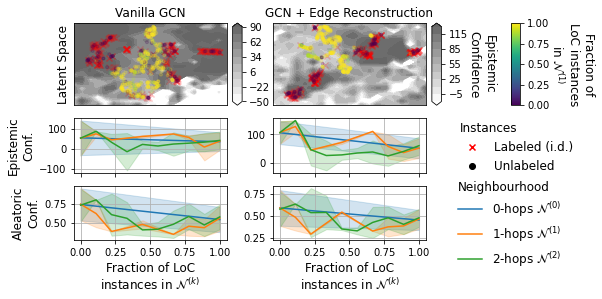

In [50]:
fig, axs2 = plt.subplots(3, 7, figsize=(8, 4), gridspec_kw={
    'wspace' : 0.1, 'hspace' : 0.2, 'width_ratios' : [0.8, 0.05, 0.1, 0.8, 0.05, 0.3, 0.05],
    'height_ratios' : [0.3, 0.2, 0.2],
})

axs = axs2[:, [0, 3, 4, 5, 6]]
for ax in axs2[1:, [1, 2]].flatten():
    ax.set_visible(False)
axs2[0, 2].set_visible(False)

c = axs[0, 0].contourf(grids['umap'][..., 0], grids['umap'][..., 1], density_grid,
                 cmap=cmap, 
                       levels=limits_to_levels(density_emb.clone()), 
                       extend='both')
for cnt in c.collections:
    cnt.set_edgecolor("face")
    
cbar = fig.colorbar(c, ax=axs[0, 0], cax=axs2[0, 1])
    
axs[0, 0].scatter(embs['umap'][:, 0][is_fit], embs['umap'][:, 1][is_fit], marker='x', alpha=.2, c='red', rasterized=True)
axs[0, 0].scatter(embs['umap'][:, 0][~is_fit], embs['umap'][:, 1][~is_fit], marker='.', alpha=.2, c=1 - fraction_id_nbs[:, 1], rasterized=True)


c = axs[0, 1].contourf(grids_norm['umap'][..., 0], grids_norm['umap'][..., 1], density_grid_norm,
                 cmap=cmap, 
                       levels=limits_to_levels(density_emb_norm.clone()), 
                       extend='both')
for cnt in c.collections:
    cnt.set_edgecolor("face")
    
cbar = fig.colorbar(c, ax=axs[0, 1], cax=axs[0, 2])
cbar.set_label('Epistemic\nConfidence', fontsize=12, rotation=270, labelpad=28)

    
axs[0, 1].scatter(embs_norm['umap'][:, 0][is_fit_norm], embs_norm['umap'][:, 1][is_fit_norm], marker='x', alpha=.2, c='red', rasterized=True)
axs[0, 1].scatter(embs_norm['umap'][:, 0][~is_fit_norm], embs_norm['umap'][:, 1][~is_fit_norm], marker='.', alpha=.2, c=1 - fraction_id_nbs[:, 1], rasterized=True)

c = axs[0, 3].scatter([0, 0], [0, 0], c=[0, 1], cmap='viridis', marker='.')
    
cbar = fig.colorbar(c, ax=axs[0, 1], cax=axs[0, 4])
cbar.set_label('Fraction of' + '\n' + r'LoC instances' + '\n' + r'in $\mathcal{N}^{(1)}$', 
               fontsize=12, rotation=270, labelpad=46)

handles = []
handles.append(axs[0, 3].scatter([0], [0], c='red', marker='x'))
handles.append(axs[0, 3].scatter([0], [0], c='black', marker='o'))

ly = 0.05

legend = fig.legend(handles, ['Labeled (i.d.)', 'Unlabeled'],
                   bbox_to_anchor=(1.01, 0.525 + ly), loc='upper right', frameon=False, fontsize=12, title='Instances')
plt.setp(legend.get_title(),fontsize=12)
legend._legend_box.align = "left"


for ax in axs[1:, 2:].flatten():
    ax.set_visible(False)
for ax in axs[0, :2].flatten():
    ax.set_xticks([])
    ax.set_yticks([])
for ax in axs[1:].flatten():
    ax.grid(which='major', axis='both')
for ax in axs[:-1, :].flatten():
    ax.set_xticklabels([])
axs[0, 3].set_visible(False)
    
axs[0, 0].set_ylabel('Latent Space', fontsize=12)
axs[1, 0].set_ylabel('Epistemic\nConf.', fontsize=12)
axs[2, 0].set_ylabel('Aleatoric\nConf.', fontsize=12)

axs[0, 0].set_title('Vanilla GCN', fontsize=12)
axs[0, 1].set_title('GCN + Edge Reconstruction', fontsize=12)

for ax in axs[-1, :].flatten():
    ax.set_xlabel(r'Fraction of LoC' + '\n' + r'instances in $\mathcal{N}^{(k)}$', fontsize=12)

def binned_xy(x, y):
    
    bin_centers = np.linspace(0, 1, 10)
    bin_idxs = np.argmin(np.abs(x[:, None] - bin_centers[None, :]), axis=1)
    
    xr, yr, sr = [], [], []
    for bin_idx in range(bin_centers.shape[0]):
        idxs = bin_idxs == bin_idx
        if idxs.sum() > 0:
            xr.append(bin_centers[bin_idx])
            yr.append(y[idxs].mean())
            sr.append(y[idxs].std())
    return np.array(xr), np.array(yr), np.array(sr)

handles = []
handle_names = []
for hops, col in enumerate(('tab:blue', 'tab:orange', 'tab:green')):
    
    xr, yr, sr = binned_xy(1 - fraction_id_nbs[:, hops].numpy(), density_emb.numpy())
    handles += (axs[1, 0].plot(xr, yr, c=col))
    handle_names.append(f'{hops}-hops '+ r'$\mathcal{N}^{(' + str(hops) + r')}$')
    axs[1, 0].fill_between(xr, yr - sr, yr + sr, alpha=.2, color=col)
    
    
    xr, yr, sr = binned_xy(1 - fraction_id_nbs[:, hops].numpy(), alea.numpy())
    axs[2, 0].plot(xr, yr, c=col)
    axs[2, 0].fill_between(xr, yr - sr, yr + sr, alpha=.2, color=col)


    xr, yr, sr = binned_xy(1 - fraction_id_nbs[:, hops].numpy(), density_emb_norm.numpy())
    axs[1, 1].plot(xr, yr, c=col)
    axs[1, 1].fill_between(xr, yr - sr, yr + sr, alpha=.2, color=col)
    
    xr, yr, sr = binned_xy(1 - fraction_id_nbs[:, hops].numpy(), alea_norm.numpy())
    axs[2, 1].plot(xr, yr, c=col)
    axs[2, 1].fill_between(xr, yr - sr, yr + sr, alpha=.2, color=col)

    
legend = fig.legend(handles, handle_names,
                   bbox_to_anchor=(0.99, 0.32 + ly), loc='upper right', frameon=False, fontsize=12, title='Neighbourhood')
plt.setp(legend.get_title(),fontsize=12)
legend._legend_box.align = "left"
#axs[1, 0].scatter(fraction_id_nbs[:, 1], density_emb, c=fraction_id_nbs[:, 1], alpha=.1)
#axs[1, 1].scatter(fraction_id_nbs[:, 1], density_emb_norm, c=fraction_id_nbs[:, 1], alpha=.1)

path = f'thesis_nbs/edge_reconstruction_nb_sensitivity/{dataset}-{setting}.pdf'
fig.savefig(path, bbox_inches='tight', dpi=200)
print(path)

In [51]:
9

9